# ERaBLE

## 1. Introduction

The problem addressed by Binet _et al._ (2016) is central to phylogenomics and involves the estimation of a species tree based on a large set of gene trees. However they do not address the topological aspect of this problem but focus on how to get meaningful branch length estimates for the species tree based on a set of homologous genomic features.

The problem is an equality constrained continuous optimization problem. The objective is a weighted least squares criterion (WLS) and the problem translates to a classic quadratic programming problem that can be solved using Lagrange multipliers. Least squares problems are known to be convex. The problem can be stated as:

** Minimize: **
$$
    Q(\hat{\alpha},\hat{b}) = \sum\limits_{k=1}^m\sum\limits_{\{i,j\} \subset L_k} w_{ij}^{(k)}(\hat{\alpha}_k\delta_{ij}-\hat{d}_{ij})^2  
$$

** subject to: **
$$
    \sum\limits_{k=1}^mZ_k\hat{\alpha}_k = \sum\limits_{k=1}^{m}Z_k
$$

Where $L_k$ is the set of taxa for which sequences of $G_k$ (gene $k$) are available, $\delta_{ij}^{(k)}$ the distance between taxon $i$ and $j$ for gene $k$ (from input distance matrix), $\hat{b}$ the estimated branch length, $\hat{\alpha}_k$ the scale factor, with $\hat{\alpha}_k = 1/\hat{r}_k$ with $\hat{r}_k$ the evolutionary rate of $G_k$.

This is the general form of the constraint, ERaBLE chooses $Z_k = N_k\sum\limits_{i,j \in L_k}\delta_{ij}^{(k)}$
with $N_k$ the alignment length of $G_k$.
    

The problem can however be rephrased in matrix notation (Additional File 1 of Binet _et al._ 2016). Let $\hat{\alpha} = (\hat{\alpha}_1, \hat{\alpha}_2, \dots, \hat{\alpha}_m)^T$ and similarly $\hat{b} = (\hat{b}_1,\hat{b}_2, \dots, \hat{b}_\tau)^T$ with $\tau = |E(\mathcal{T})|$ where $\mathcal{T}$ denotes the tree topology graph. Let $\delta_k$ be the vector with all pairwise distances $\delta_{ij}^{(k)}$ for $G_k$. Similarly, let $\hat{d}$ be the vector with all additive distances from $\hat{b}$ and let $\hat{d}_k$ denote the vector of all additive distances for the taxa included in $L_k$.

We now define the topological matrix $A$ that represents the topology $\mathcal{T}$ as the $n(n-1)/2 \times \tau$ matrix where each row corresponds to a pair of taxa and each column to a branch in $\mathcal{T}$. Let $a_{ij,e}$ be the element for pair of taxa $i$ and $j$ for branch $e$, $a_{ij,e}$ is set to $1$ if $e$ is on the path between $i$ and $j$, and to $0$ otherwise. Similar as with the definition of $\hat{d}_k$, let $A_k$ be the $|L_k|(|L_k|-1)/2 \times \tau$ matrix obtained by removing all pairs of taxa that are not present in in $L_k$. Now $\hat{d} = A\hat{b}$ and $\hat{d}_k = A_k\hat{b}$.

Let $W_k$, the weight matrix, be the square matrix with as diagonal elements $w_{ij}^{(k)}$ and all other elements set to $0$. Finally let $z = (Z_1,Z_2,\dots,Z_m)^T$ and $Z=\sum\limits_{k=1}^{m}Z_k$.

The WLS problem can now be expressed as:

** Minimize: **
$$
    Q(\hat{\alpha},\hat{b}) = \sum\limits_{k=1}^m(\hat{\alpha}_k\delta_k - A_k\hat{b})^TW_k(\hat{\alpha}_k\delta_k - A_k\hat{b})
$$

** Subject to: **
$$
    z^T\hat{\alpha} = Z
$$

This problem can be solved using the method of Lagrange multipliers. The Lagrangian function is:

$$\mathcal{L}(\hat{\alpha},\hat{b},\lambda) = Q(\hat{\alpha},\hat{b})+\lambda(z^T\hat{\alpha}-Z)$$

A necessary and sufficient condition for the tuple $(\hat{\alpha}, \hat{b})$ to be an optimal solution for the above problem is that the gradient of the Lagrangian is zero _i.e._ $\nabla_{\hat{\alpha},\hat{b},\lambda}\mathcal{L}(\hat{\alpha}, \hat{b}, \lambda) = 0$, note that this is sufficient since the WLS problem is convex. We get the system of equations:

$$
    \frac{\partial\mathcal{L}}{\partial\hat{\alpha}_k} = 0
$$
$$
    \frac{\partial\mathcal{L}}{\partial\hat{b}} = 0
$$
$$
    \frac{\partial\mathcal{L}}{\partial\lambda} = 0
$$

Which results in:

$$
    \hat{\alpha}_k\delta_k^TW_k\delta_k - \delta^TW_kA_kb + \lambda z^T/2 = 0
$$
$$
    \sum\limits_{k=1}^{m}(A_k^TW_kA_k\hat{b} - \hat{\alpha}_kA_k^tW_k\delta_k) = 0
$$
$$
    z^T\hat{\alpha} -Z = 0
$$

Here the first equation is a system of $m$ equations (with $m$ the number of genes), the second a system of $\tau$ equations (with $\tau$ the number ofb branches) and the last consist of one equation. This can be rewritten as:

$$
    D\hat{\alpha} + B^T\hat{b} + \lambda z = 0
$$
$$
    B\hat{\alpha} + C\hat{b} = 0
$$
$$
    z^T\hat{\alpha}=Z
$$
With $D = \delta_k^TW_k\delta_k$, $B^T = - \delta^T_kW_kA_k$ and $C = \sum\limits_{k=1}^mA^T_kW_kA_k$. The $1/2$ coeffici&euml;nt was dropped, as we are not interested in the value of the Lagrange multiplier. This system can be solved naively by matrix multiplication in $O(mn^4)$ time. Note that $Z_k = N_k\sum\limits_{i,j \in L_k}\delta_{ij}^{(k)}$ with $N_k$ the alignment length of $G_k$

## 2. Calculation of distances

Some functions to get distance matrices from a bunch of multiple sequence alignments.

In [2]:
from numpy import inf
from heapq import heappop, heappush, heappushpop, heapify
import numpy as np
import pandas as pd
import os
import re
import itertools
from ete3 import Tree
import matplotlib.pyplot as plt
import timeit
from io import StringIO
%matplotlib inline

In [3]:
species = {
    'arath': re.compile('AT[^R].+'),
    'ambtr': re.compile('ATR.+'),
    'chlre': re.compile('CR.+'),
    'phypa': re.compile('PP.+'),
    'poptr': re.compile('PT.+'),
    'orysa': re.compile('OS.+'),
    'zeama': re.compile('ZM.+'),
    'zosma': re.compile('Zosma.+'),
    'ulvmu': re.compile('evm.+'),
    'vitvi': re.compile('VV.+'),
    'thepa': re.compile('TP.+'),
    'bradi': re.compile('BD.+'),
    'spipo': re.compile('Spipo.+'),
    'caros': re.compile('Caros.+'),
    'ostta': re.compile('OT.+')
}

def proportion_different_sites(s1, s2):
    """
    Calculate the proportion of different sites between pairwise sequences
    :param s1:
    :param s2:
    :return:
    """
    p = 0
    for i in range(len(s1)):
        if s1[i] != s2[i]:
            p += 1
    return p/len(s1)


def jukes_cantor(s1, s2):
    """
    Implementation of the JC69 model (Jukes & Cantor, 1969) which assumes
    that every nucleotide has the same instantaneous rate of changing into another
    nucleotide (an assumption that is almost never valid).
    :return:
    """
    p = proportion_different_sites(s1, s2)
    d = -(3/4)*np.log(1-(4/3)*p)
    var_d = (p*(1-p)/len(s1))*(1/(1-4*p/3))
    return d, var_d


def distance_matrix(msa, distance='JC69'):
    """
    Function to get a distance matrix from a multiple sequence alignment
    :param msa: dictionary with aligned sequences
    :param distance: distance metric to use (currently only JC69 supported)
    :return: distance matrix (pandas data frame)
    """
    l = list(msa.keys())
    df = pd.DataFrame(np.zeros((len(l),len(l))), index=l, columns=l)
    
    for i in range(len(list(df.index))):
        gene_1 = df.index[i]
        
        for j in range(i+1,len(list(df.index))):
            gene_2 = df.index[j]
            
            if distance == 'JC69':
                d = jukes_cantor(msa[gene_1], msa[gene_2])
                df[gene_1][gene_2] = d[0]
                df[gene_2][gene_1] = d[0]
    
    return df


def read_msa(msa):
    """
    Read multiple sequence alignment (MSA) in PHYLIP format.
    :param msa: MSA file
    :return: dictionary
    """
    msa_dict = {}
    
    with open(msa, 'r') as f:
        content = f.readlines()
        
    n_seq, length = int(content[0].split()[0].strip()), int(content[0].split()[1].strip())

    for i in range(1,n_seq*2,2):
        msa_dict[content[i].strip()] = content[i+1].strip()
            
    return msa_dict


def get_species(gene, species):
    """
    Get species for a gene using regex matches.
    """
    for sp, p in species.items():
        if p.match(gene):
            return sp
    raise ValueError("species not found for gene {}!".format(gene))
    

def collapse_on_species(distance_matrix, species):
    """
    Collapse a given distance matrix for a gene family on species level.
    Distances for duplicates within a species are averaged.
    """
    matrix = pd.DataFrame()
    sp_set = set()
    to_drop = []
    for gene in distance_matrix.index:
        sp = get_species(gene, species)
        if sp in sp_set:
            matrix[sp] += distance_matrix[gene]
            matrix[sp] /= 2
            to_drop.append(gene)
        else:
            matrix[sp] = distance_matrix[gene]
            sp_set.add(sp)
        
    matrix = matrix.drop(to_drop)
    matrix.index = matrix.columns
    
    for k in range(len(matrix.index)):
        matrix.iloc[k,k] = 0
    return matrix


def parse_distance_matrices(distances_file):
    """
    Parse ditances as provided by ERaBLE authors

    :param distances_file: file with distance matrices
    :return: distances data frames in list and sequence lengths
    """
    lengths = []
    matrices = []

    with open(distances_file, 'r') as f:
        content = f.read()

    content = content.split('\n\n')
    for mat in content[1:]:
        mat = mat.split('\n')
        i = 0
        for i in range(len(mat)):
            if mat[i] != '':
                break
        if len(mat[i].split()) == 2:
            lengths.append(int(mat[i].strip().split()[1]))
            matrix = pd.read_csv(StringIO("\n".join(mat[i + 1:])), sep="\s+", header=None, index_col=0)
            matrix.columns = matrix.index
            matrices.append(matrix)

    return matrices, lengths

## 3. Helper functions for ERaBLE

In [4]:
def topology_matrix_dijkstra(tree, species):
    """
    Input: newick tree
    Output: topology matrix
    """
    t = Tree(tree)
    i = len(species)
    for node in t.traverse():
        if node.name in species:
            node.name = species[node.name]
        else:
            node.name = i
            i += 1

    graph = tree_to_adj_list(t)
    leaves = list(t.get_leaves())
    paths = {}
    branches = set()
    for i in range(len(leaves)):
        node1 = leaves[i]
        for j in range(i + 1, len(leaves)):
            node2 = leaves[j]
            path, distance = dijkstra(graph, node1.name, node2.name)
            path = [(path[x], path[x + 1]) for x in range(len(path) - 1)]
            paths[tuple(sorted([node1.name, node2.name]))] = path
            for p in path:
                p = tuple(sorted(p))
                if p not in branches:
                    branches.add(p)

    # put in a matrix
    df = pd.DataFrame(index=list(paths.keys()), columns=list(branches))
    for tup, path in paths.items():
        for branch in path:
            branch = tuple(sorted(branch))
            df[branch][tup] = 1
    df = df.fillna(0)
    df.sort_index(0, inplace=True)
    df.sort_index(1, inplace=True)
    return df, t


def dijkstra(graph, source, sink=None):
    """
    Implementation of Dijkstra's shortest path algorithm
    Inputs:
        - graph : dict representing the weighted graph
        - source : the source node
        - sink : the sink node (optional)
    Ouput:
        - distance : dict with the distances of the nodes to the source
        - came_from : dict with for each node the came_from node in the shortest
                    path from the source
    """
    distance = {v: inf for v in graph}
    distance[source] = 0
    current = source
    previous = {}
    Q = [(source, 0)]

    while Q:
        U = heappop(Q)
        if sink and U == sink:
            break
        for V in graph[U[0]]:
            alt = distance[U[0]] + V[0]
            if alt < distance[V[1]]:
                distance[V[1]] = alt
                previous[V[1]] = U[0]
                heappush(Q, (V[1], alt))

    if sink is None:
        return distance, previous
    else:
        return reconstruct_path(previous, source, sink), distance[sink]


def reconstruct_path(previous, source, sink):
    """
    Reconstruct the path from the output of the Dijkstra algorithm
    Inputs:
            - previous : a dict with the came_from node in the path
            - source : the source node
            - sink : the sink node
    Ouput:
            - the shortest path from source to sink (list)
    """
    if sink not in previous:
        return []

    V = sink
    path = [V]
    while V != source:
        V = previous[V]
        path.append(V)
    return path


def tree_to_adj_list(tree):
    """
    Convert ete3 Tree object to an adjacency list representing the tree graph
    """
    adj_list = {}
    for node in tree.traverse('postorder'):
        l = []
        if not node.is_leaf():
            # add children
            l += [(1, c.name) for c in node.children]
        if not node.is_root():
            # add parent
            l.append((1, node.up.name))
        adj_list[node.name] = set(l)
    return adj_list


def code_species(species):
    """
    Code species to integers
    """
    if type(species) == dict:
        species = list(species.keys())
    species_to_int = {x: 0 for x in species}
    i = 0
    for x in sorted(species):
        species_to_int[x] = i
        i += 1
    return species_to_int


def sub_topology_matrix(subset, matrix):
    """
    Get topology matrix for a subset of taxa
    """
    to_drop = []
    for pair in matrix.index:
        if pair[0] not in subset or pair[1] not in subset:
            to_drop.append(pair)
    matrix = matrix.drop(to_drop)
    return matrix


def sequence_length(msa_file):
    """
    Construct a weight matrix. Using alignment length as weight.
    """
    with open(msa_file, 'r') as f:
        content = f.readlines()

    length = int(content[0].split()[1].strip())
    return length


def weight_matrix(length, s):
    """
    Construct a weight matrix. Using alignment length as weight.
    """
    return np.diag([length for i in range(s)])


def vectorize_delta(delta):
    """
    Convert distance matrix to vector
    """
    d = np.array(delta)
    l = []
    for i in range(0, len(d)):
        for j in range(i + 1, len(d)):
            l.append(d[i, j])
    return np.array(l)


def add_branch_lengths(tree, branches, species_mapping):
    """
    Add branch lengthhs to an ete3 tree object
    """
    inv_map = {v: k for k, v in species_mapping.items()}
    for node in tree.traverse('postorder'):
        if not node.is_root():
            branch = tuple(sorted([node.name, node.up.name]))
            node.dist = float(branches[branch])
            if node.is_leaf():
                node.name = inv_map[node.name]
    return tree

## 4. ERaBLE implementation

In [5]:
def solve_naively(D, B, C, z, Z):
    naive = np.bmat(
        [[D, B.T, z],
         [B, C, np.ones((B.shape[0], 1))],
         [z.T, np.zeros((1, C.shape[1])), np.array(0).reshape(1, 1)]]
    )
    right = np.zeros((1, naive.shape[0]))
    right[:, -1] = Z
    right = right.reshape(-1, 1)
    solution = np.linalg.solve(naive, right)

    return solution[D.shape[0]:-1], solution[:D.shape[0]]

In [6]:
def solve_cleverly(D, B, C, z, Z):
    # invert D, D is a diagonal matrix so inverse is just diagonal elements^-1
    D_inv = 1/D
    D_inv[np.isinf(D_inv)] = 0

    u = B @ D_inv @ z
    w = (z.T @ D_inv @ z)[0][0]
    M = C + ((1 / w) * u @ u.T) - B @ D_inv @ B.T
    # print(M)
    b = np.linalg.solve(M, -(Z / w) * u)
    alpha = D_inv @ ((z @ u.T / w) - B.T) @ b + (Z / w) * D_inv @ z
    # alpha = D_inv @ ((z.reshape((1,-1)) @ u.reshape((-1,1)))/w - B.T) @ b + (Z/w)*D_inv @ z
    # alpha[alpha == 0] = 0.0001 # this shouldn't be necessary

    return b, alpha

In [7]:
def erable(tree_file, species_mapping, distance_matrices, lengths, naive=False, subset=False):
    """
    ERaBLE main function
    """
    A, t = topology_matrix_dijkstra(tree_file, species_mapping)
    # print(A, t, species_mapping)

    # construct C
    C = np.zeros((A.shape[1], A.shape[1]))
    weights = []
    Aks = []
    z = []
    Nks = []

    for k in range(len(distance_matrices)):
        distance_matrices[k].sort_index(0, inplace=True)
        distance_matrices[k].sort_index(1, inplace=True)

    D = np.zeros((len(distance_matrices), len(distance_matrices)))
    B = np.zeros((A.shape[1], len(distance_matrices)))

    for k in range(len(distance_matrices)):
        if subset:
            taxa = [species_mapping[x.name] for x in Tree(tree_file).get_leaves()]
            sub = set(taxa) & set(distance_matrices[k].index)
            dist = distance_matrices[k][list(sub)]
            dist = dist.ix[list(sub)]
        else:
            dist = distance_matrices[k]
        delta = vectorize_delta(dist).reshape(-1, 1)
        Ak = sub_topology_matrix(set(dist.index), A)
        Nk = lengths[k]
        Nks.append(Nk)
        Wk = weight_matrix(Nk, len(delta))
        C += Ak.T @ Wk @ Ak
        weights.append(Wk)
        Aks.append(Ak)
        D[k, k] = delta.T @ Wk @ delta
        B[:, k] = list(-Ak.T @ Wk @ delta)
        Zk = Nk * delta.sum()
        z.append(Zk)

    Z = sum(z)
    z = np.array(z).reshape(-1, 1)

    # return D, B, z, C, Z

    if naive:
        b, alpha = solve_naively(D, B, C, z, Z)

    else:
        b, alpha = solve_cleverly(D, B, C, z, Z)

    # calculate scaling factor
    c = (1 / sum(Nks)) * sum([Nks[i] / alpha[i] for i in range(len(Nks))])

    # rescale
    r = 1 / (c * alpha)
    b = c * b
    
    branches = {}
    for i in range(len(b)):
        branches[A.columns[i]] = b[i]

    return (b, r, c, t, branches)

## 5. Toy example from ERaBLE

Here, a test is performed on a small toy data set included in the ERaBLE distribution (http://www.atgc-montpellier.fr/erable/usersguide.php) to check whether the implementation is correct.

In [28]:
mats, lengths = parse_distance_matrices('./data/example.txt')

tree_file = 'data/example.nwk'
tree_s = '((Tax10:0.51144,(Tax34:0.19411,(Tax20:0.19064,Tax4:0.15564)1:0.09995)1:0.09856),(Tax14:0.10233,Tax3:0.03293)1:0.01914);'
species = [n.name for n in Tree(tree_s).get_leaves()]
species_mapping = code_species(species)

for delta_matrix in mats:
    delta_matrix.index = [species_mapping[x] for x in delta_matrix.index]
    delta_matrix.columns = list(delta_matrix.index)

lengths = [382, 210, 590]

The topology matrix for this problem looks like this:

In [31]:
topology_matrix_dijkstra(species=species_mapping, tree=tree_file)[0]

,"(0, 6)","(1, 8)","(2, 9)","(3, 8)","(4, 7)","(5, 9)","(6, 7)","(6, 8)","(7, 9)"
"(0, 1)",1,1,0,0,0,0,0,1,0
"(0, 2)",1,0,1,0,0,0,1,0,1
"(0, 3)",1,0,0,1,0,0,0,1,0
"(0, 4)",1,0,0,0,1,0,1,0,0
"(0, 5)",1,0,0,0,0,1,1,0,1
"(1, 2)",0,1,1,0,0,0,1,1,1
"(1, 3)",0,1,0,1,0,0,0,0,0
"(1, 4)",0,1,0,0,1,0,1,1,0
"(1, 5)",0,1,0,0,0,1,1,1,1
"(2, 3)",0,0,1,1,0,0,1,1,1


Now let's run the ERaBLE implementation:

In [33]:
b, r, c, t, branches = erable(tree_file=tree_file, species_mapping=species_mapping, 
                  distance_matrices=mats, lengths=lengths)
b_, r_, c_, t_, branches_ = erable(tree_file=tree_file, species_mapping=species_mapping, 
                  distance_matrices=mats, lengths=lengths, naive=True)

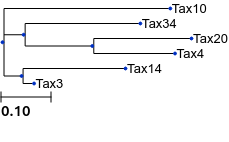

In [34]:
t = add_branch_lengths(t_, branches_, species_mapping)
t.render(file_name='%%inline')

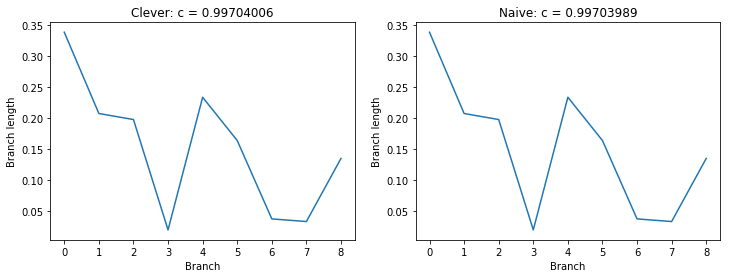

In [37]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.plot(range(len(b)), b)
ax.set_ylabel('Branch length')
ax.set_xlabel('Branch')
ax.set_title('Clever: c = {:.8f}'.format(c[0]))
ax = fig.add_subplot(122)
ax.plot(range(len(b_)), b_)
ax.set_title('Naive: c = {:.8f}'.format(c_[0]))
ax.set_ylabel('Branch length')
ax.set_xlabel('Branch')

In [42]:
print('Gene-wise rates: ')
for i in range(len(r)):
    print('{0:.8f} --- {1:.8f}'.format(r[i][0], r_[i][0]))

Gene-wise rates: 
1.62884031 --- 1.62883966
0.48603694 --- 0.48603710
0.77578855 --- 0.77578891


The results are virtually the same for both solving methods. Also they are quasi identical to the results obtained with the distributed version (C++) of ERaBLE ($c=0.997023$).

In [101]:
%timeit erable(tree_file=tree_file, species_mapping=species_mapping, distance_matrices=mats, lengths=lengths)
%timeit erable(tree_file=tree_file, species_mapping=species_mapping, distance_matrices=mats, lengths=lengths, naive=True)

100 loops, best of 3: 14.3 ms per loop
100 loops, best of 3: 13.7 ms per loop


The execution times are also similar, maybe the 'clever' solution was not cleverly implemented after all.

## 6. OrthoMaM data set

OrthoMaM (Ranwez _et al._, 2007) is a database for mammalian marker genes with one-to-one orthologous relations across multiple genomes selected on EnsEMBL genomes (http://www.orthomam.univ-montp2.fr/orthomam/html/). Besides using simulated data, Binet _et al._ used the OrthoMaM dataset for benchmarking ERaBLE as a real world example. Here the Python implementation is tested on the same data set.

### Pre-process the data

In [9]:
matrices, lengths = parse_distance_matrices('./data/orthomam_distances.txt')
tree_file = './data/orthomam.nwk'
tree = Tree(tree_file)
species = [n.name for n in tree.get_leaves()]
species_mapping = code_species(species)
for delta_matrix in matrices:
    delta_matrix.index = [species_mapping[x] for x in delta_matrix.index]
    delta_matrix.columns = list(delta_matrix.index)

### Experiments

#### Scaling with $m$ (number of genes)

In [121]:
sizes = [100,200,300,400,500,750,1000,1500,2000,3000]
times = []
for size in sizes:
    print('m = {:>4}'.format(size), end=', ')
    t = timeit.timeit(lambda: erable(tree_file=tree_file, species_mapping=species_mapping,
                                     distance_matrices=matrices[:size], lengths=lengths),
                      number=1)
    print('t = {:>4.2f}'.format(t), end=' | ')
    times.append(t)

m =  100, t = 7.08 | m =  200, t = 12.26 | m =  300, t = 17.05 | m =  400, t = 23.07 | m =  500, t = 27.20 | m =  750, t = 43.23 | m = 1000, t = 52.43 | m = 1500, t = 81.46 | m = 2000, t = 107.68 | m = 3000, t = 161.53 | 

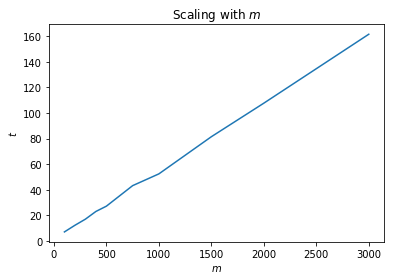

In [125]:
plt.plot(sizes, times)
plt.xlabel('$m$')
plt.ylabel('$t$')
plt.title('Scaling with $m$')

The implementation of ERaBLE seems to scale linearly in the number of genes. This is expected under the effcient implementation, for which the authors showed that the computational complexity is $O(mn^2 +n^3)$.

#### Scaling with $\tau$ (or $n$, number of taxa)

In [132]:
sizes = [5,6,7,8,9,11,12,14,15,16,17,18]
ns = []
times = []
for size in sizes:
    n = tree.get_leaves_by_name('Homo')[0]
    for i in range(size):
        n = n.up
    n.write(outfile='tmp.tree')

    print('n = {:>2}'.format(len(n)), end= ', ')
    t = timeit.timeit(lambda: erable(tree_file='tmp.tree', species_mapping=species_mapping,
                                     distance_matrices=matrices[:5000], lengths=lengths,
                                     subset=True),
                      number=1)
    ns.append(len(n))
    print('t = {:>4.2f}'.format(t), end = ' | ')
    times.append(t)

n =  6, t = 15.75 | n =  7, t = 14.67 | n =  8, t = 14.97 | n = 10, t = 15.63 | n = 11, t = 15.70 | n = 27, t = 76.97 | n = 29, t = 96.76 | n = 35, t = 206.79 | n = 36, t = 194.30 | n = 37, t = 213.46 | n = 38, t = 245.82 | n = 40, t = 319.96 | 

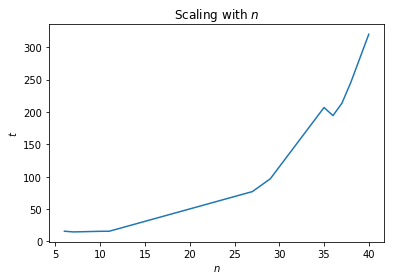

In [136]:
plt.plot(ns, times)
plt.xlabel('$n$')
plt.ylabel('$t$')
plt.title('Scaling with $n$')
plt.savefig('../scaling_n.png', dpi=200)
plt.show()

ERaBLE seems to scale approximately quadratic with $n$ ($\tau = |\mathcal{T}|$). As the complexity should be $O(mn^2 +n^3)$, this is the expected behavior for the case where $m > n$ (which is usually the case in phylogenomics analyses).

### Full analysis on OrthoMaM 

A run on al 6953 genes for all species.

In [10]:
%%time
b, r, c, t, branches = erable(tree_file=tree_file, species_mapping=species_mapping, 
                              distance_matrices=matrices, lengths=lengths)

CPU times: user 7min 26s, sys: 14min 43s, total: 22min 9s
Wall time: 5min 48s


This is way slower than the implementation of the Binet _et al._ (2016). However, the experiments show that it does scale as described.

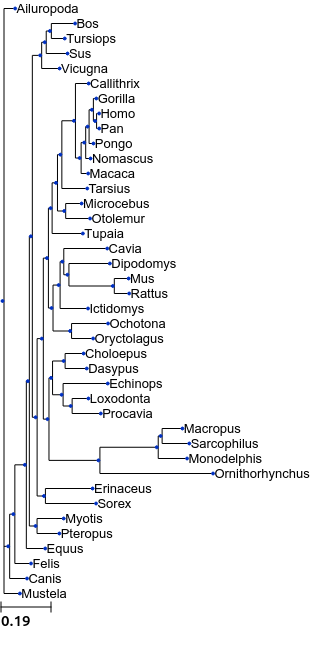

In [11]:
t = add_branch_lengths(t, branches, species_mapping)
t.render(file_name='%%inline')

Now the tree can be rooted with the platypus (_Ornithorhynchus_) as outgroup to get a nice view on mammalian evolution! With branch lengths!

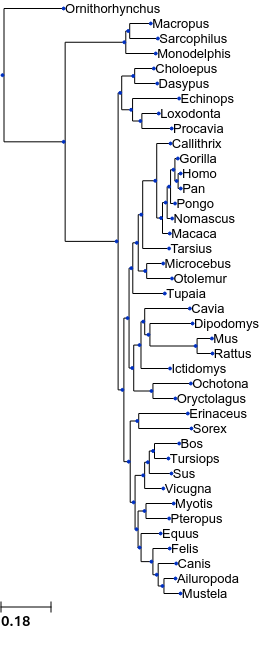

In [13]:
t.set_outgroup('Ornithorhynchus')
t.render(file_name='%%inline')

We can also check the gene-wise relative evolutionary rates

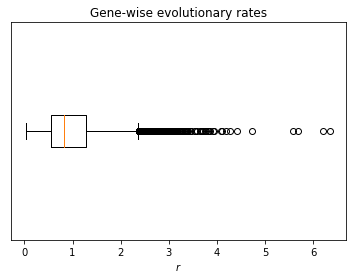

In [25]:
plt.boxplot(r, vert=False)
plt.title('Gene-wise evolutionary rates')
plt.xlabel('$r$')
plt.yticks([])
plt.show()

Which shows a expected that most genes have low (putative purifying selection) or about average rates and a few genes with really high rates, whcih may point to positive selection or incomplete pseudogenization.  

## References

1. Binet, M., Gascuel, O., Scornavacca, C., P. Douzery, E. J., & Pardi, F. (2016). Fast and accurate branch lengths estimation for phylogenomic trees. BMC Bioinformatics, 17(1), 23. https://doi.org/10.1186/s12859-015-0821-8

2. Ranwez, V., Delsuc, F., Ranwez, S., Belkhir, K., Tilak, M.-K., & Douzery, E. J. P. (2007). OrthoMaM: A database of orthologous genomic markers for placental mammal phylogenetics. BMC Evolutionary Biology, 7(1), 241. article. https://doi.org/10.1186/1471-2148-7-241